<a href="https://colab.research.google.com/github/nbilasals/indonesia_salary_forecast/blob/main/umr_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Regional Salaries (UMR) in Indonesia Using Time Series

## Project Domain

This project focuses on forecasting regional salaries in Indonesia using time series analysis. Regional salary data is important to monitor as it reflects the economic conditions of different regions and helps policymakers, businesses, and job seekers make informed decisions.

The problem arises from the lack of accessible and reliable salary forecasts, which are critical for planning workforce strategies and improving economic policies.

**Why Solve This Problem?**
1. Salary forecasting helps businesses plan recruitment budgets.
2. Policymakers can use the forecasted data to address economic gaps between regions.
3. Forecasting can help job seekers understand future trends and improve financial planning.

## Import Required Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import os
import shutil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir -p ~/.kaggle
shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d linkgish/indonesian-salary-by-region-19972022

Dataset URL: https://www.kaggle.com/datasets/linkgish/indonesian-salary-by-region-19972022
License(s): GPL-2.0
  0% 0.00/5.08k [00:00<?, ?B/s]
100% 5.08k/5.08k [00:00<00:00, 8.58MB/s]


In [10]:
!unzip indonesian-salary-by-region-19972022.zip

Archive:  indonesian-salary-by-region-19972022.zip
  inflating: Indonesian Salary by Region (1997-2022).csv  


In [11]:
df = pd.read_csv("Indonesian Salary by Region (1997-2022).csv")
df

,REGION,SALARY,YEAR
0,ACEH,128000,1997
1,SUMATERA UTARA,151000,1997
2,SUMATERA BARAT,119000,1997
3,RIAU,151500,1997
4,JAMBI,119500,1997
...,...,...,...
865,MALUKU,2619312,2022
866,MALUKU UTARA,2862231,2022
867,PAPUA BARAT,3200000,2022
868,PAPUA,3561932,2022


### Exploratory Data Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  870 non-null    object
 1   SALARY  870 non-null    int64 
 2   YEAR    870 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 20.5+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SALARY,870.0,1.179872e+06,917543.542926,106000.0,421500.0,890387.5,1867582.75,4452724.0
YEAR,870.0,2.009816e+03,7.453930,1997.0,2003.0,2010.0,2016.00,2022.0


In [19]:
# Calculate the average salary per year, excluding non-numeric columns
avg = df.groupby(["YEAR"])['SALARY'].mean().reset_index()
avg

,YEAR,SALARY
0,1997,1.349643e+05
1,1998,1.509375e+05
2,1999,1.753906e+05
3,2000,2.165062e+05
4,2001,2.904875e+05
5,2002,3.645812e+05
6,2003,4.149281e+05
7,2004,4.573469e+05
8,2005,5.076968e+05
9,2006,6.091666e+05


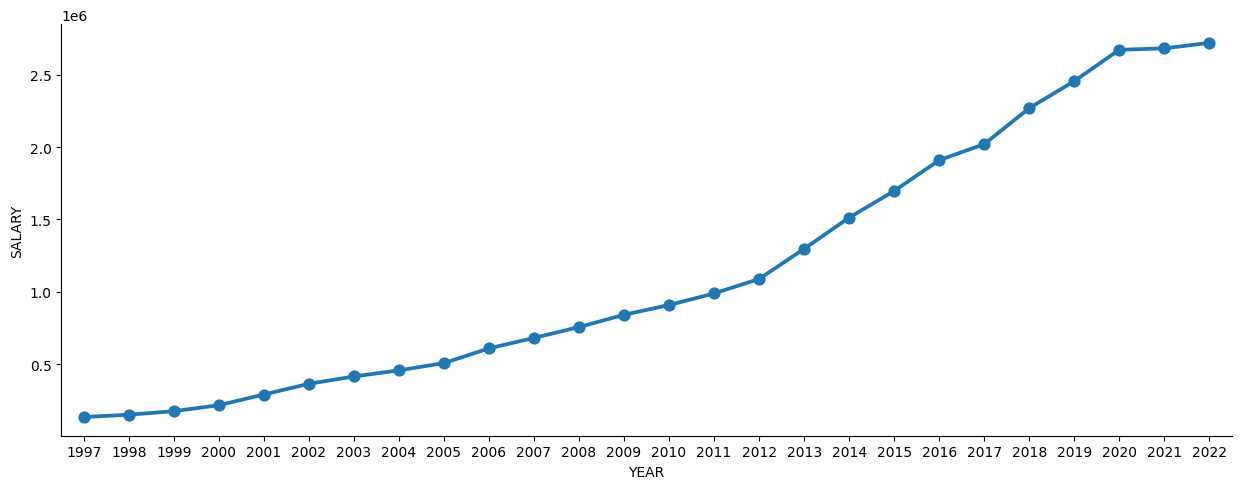

In [20]:
# Create the catplot using the 'avg' DataFrame
sns.catplot(x='YEAR', y='SALARY', data=avg, kind='point', aspect=2.5)

In [24]:
# Calculate salary growth of country by year

growth=[0]
for i in range(1,26):
    growth.append(avg["SALARY"][i]-avg["SALARY"][i-1])

avg["growth"]=growth
avg

,YEAR,SALARY,growth
0,1997,1.349643e+05,0.000000
1,1998,1.509375e+05,15973.214286
2,1999,1.753906e+05,24453.125000
3,2000,2.165062e+05,41115.625000
4,2001,2.904875e+05,73981.250000
5,2002,3.645812e+05,74093.750000
6,2003,4.149281e+05,50346.875000
7,2004,4.573469e+05,42418.750000
8,2005,5.076968e+05,50349.937500
9,2006,6.091666e+05,101469.746324


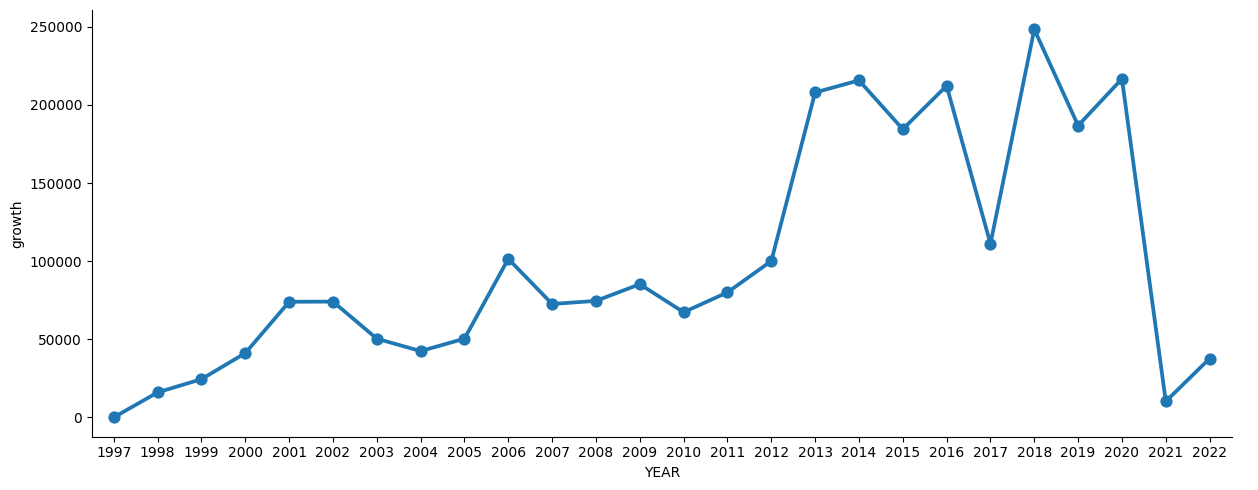

In [25]:
#Plot growth per year
sns.catplot(x='YEAR', y='growth', data=avg, kind='point', aspect=2.5)

From the chart above, we can see that 2018 had the highest average UMP (Provincial Minimum Wage) in the observed period, followed by 2020 and 2014. On the other hand, the lowest UMP values occurred in 2021, with 1998 and 1999 not far behind. This sharp decline in 2021 can likely be attributed to the economic impacts of the COVID-19 pandemic, which disrupted labor markets and led to wage stagnation. Similarly, the dip in 1998 and 1999 corresponds with the financial crisis that severely affected Indonesia's economy, pushing wages to their lowest point in recent history. These events highlight how external factors, such as global pandemics and financial crises, can deeply influence regional wage trends.

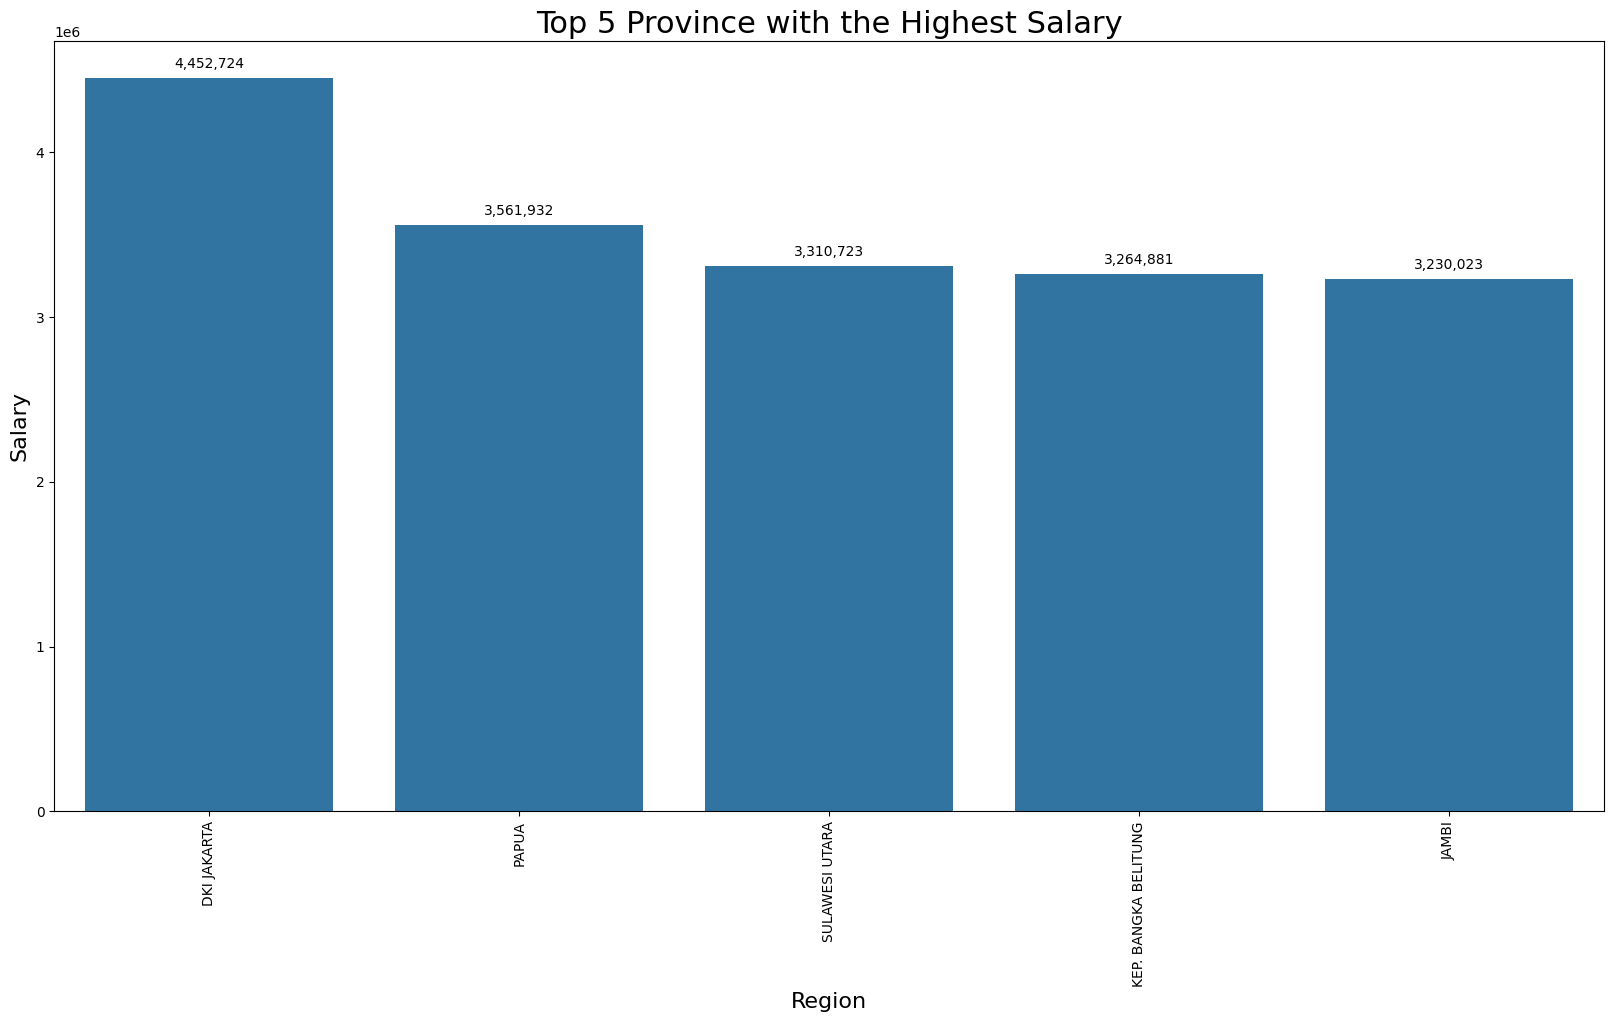

In [35]:
#5 Province with Highest Salary

top_5_regions = df.groupby('REGION')['SALARY'].max().sort_values(ascending=False)[:5]
top_5_regions = top_5_regions.reset_index()

plt.figure(figsize = (20, 10))
graph = sns.barplot(x = 'REGION', y = 'SALARY', data=top_5_regions, order=top_5_regions['REGION'])
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
plt.xlabel('Region', fontsize=16)
plt.ylabel('Salary', fontsize=16)
plt.title('Top 5 Province with the Highest Salary', fontsize=22)

for index, row in top_5_regions.iterrows():
    graph.annotate(format(int(row['SALARY']), ','),
                   (row.name, row['SALARY']),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

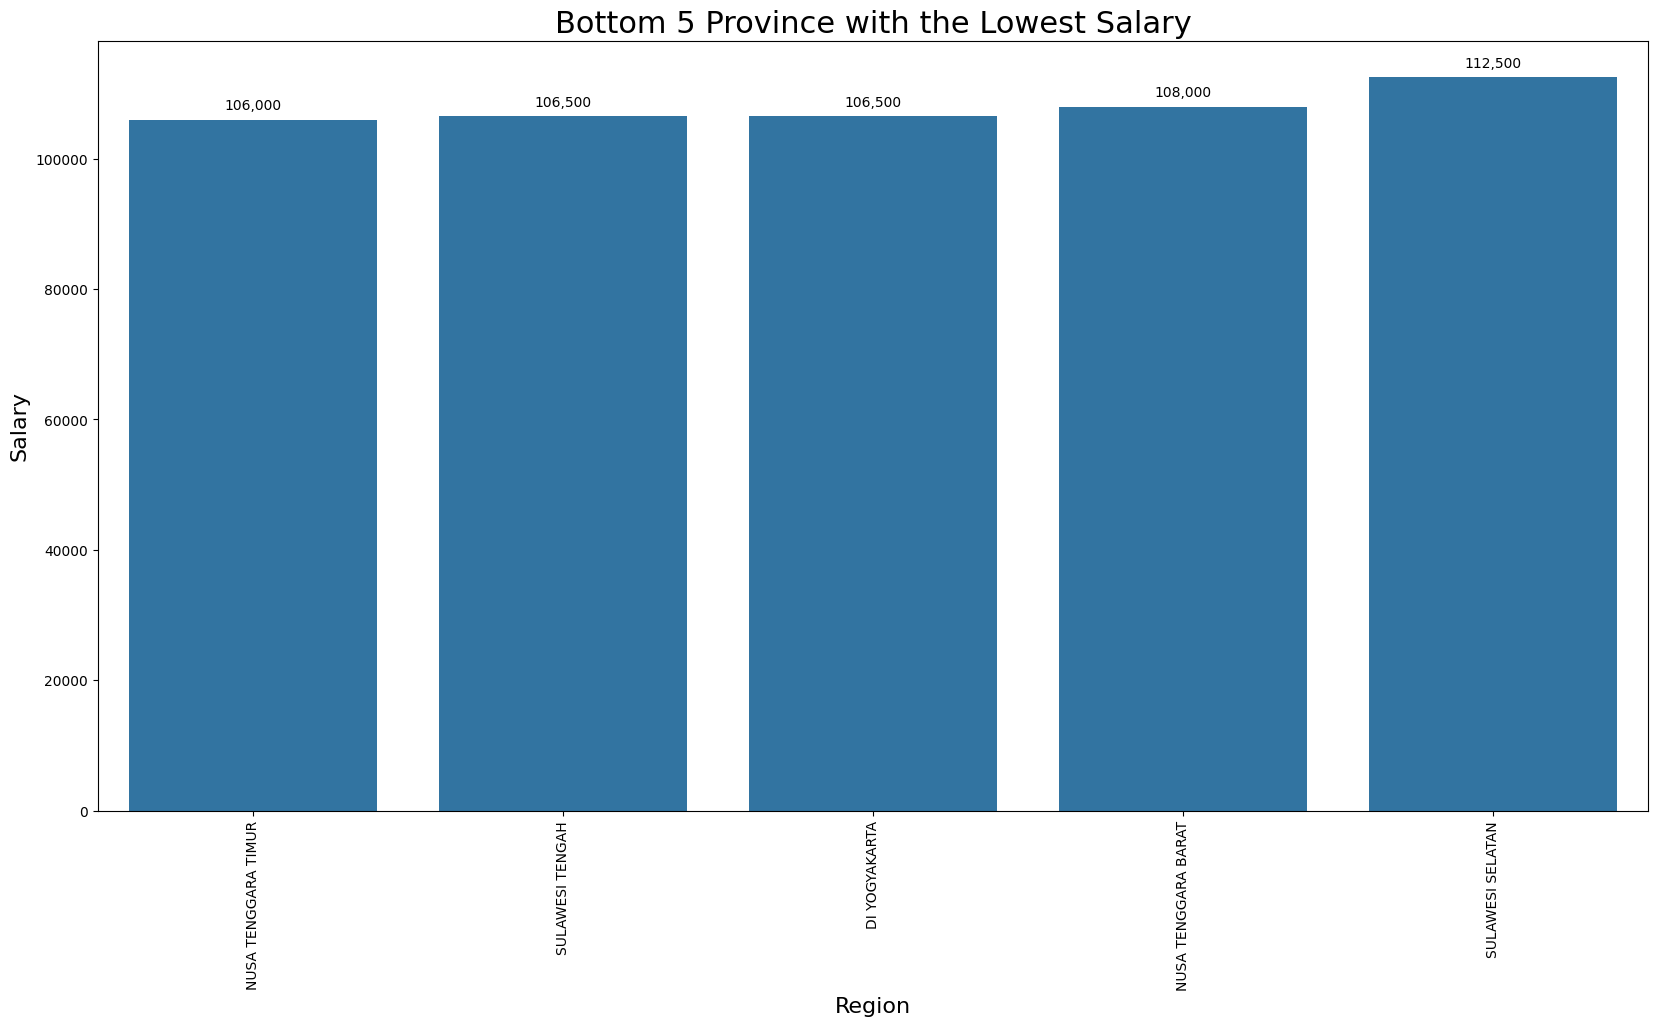

In [36]:
# Get the 5 regions with the lowest salary
bottom_5_regions = df.groupby('REGION')['SALARY'].min().sort_values(ascending=True)[:5]
bottom_5_regions = bottom_5_regions.reset_index()

# Plot the results
plt.figure(figsize = (20, 10))
graph = sns.barplot(x = 'REGION', y = 'SALARY', data=bottom_5_regions, order=bottom_5_regions['REGION'])
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
plt.xlabel('Region', fontsize=16)
plt.ylabel('Salary', fontsize=16)
plt.title('Bottom 5 Province with the Lowest Salary', fontsize=22)

# Annotate salary values on the bars
for index, row in bottom_5_regions.iterrows():
    graph.annotate(format(int(row['SALARY']), ','),  # Format the salary with commas (e.g., 1,000,000)
                   (row.name, row['SALARY']),  # Position the annotation at the (x, y) coordinates
                   ha='center', va='center',   # Horizontally and vertically center the annotation
                   xytext=(0, 10),             # Offset the text a little bit upwards (10 units)
                   textcoords='offset points')  # The offset is in points

plt.show()


### Data Preprocessing

#### Split Dataset

## Modelling

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)